# Train a simple harmonic oscillator using an online learning rule

Challenge: get the system to exhibit stable oscillations when neurons have a low maximum firing rate

# Utilities

```pip install numpy scipy pandas nengo nengolib matplotlib seaborn hyperopt```

In [ ]:
import numpy as np

import pandas as pd

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, base

import nengo
from nengo import SpikingRectifiedLinear as ReLu
from nengo.dists import Uniform, Choice
from nengo.solvers import NoSolver, LstsqL2
from nengo.utils.numpy import rmse
from nengo.params import Default, NumberParam
from nengo.builder import Builder, Operator, Signal
from nengo.builder.neurons import NeuronType, SimNeurons
from nengo.builder.connection import BuiltConnection

from nengolib import Lowpass, DoubleExp
from nengolib.synapses import ss2sim
from nengolib.signal import LinearSystem, cont2discrete

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

### Define neuron models
Note that I override the default ```gain_bias``` and ```max_rates_intercepts``` methods, because
 - all weights will be learned online
 - I avoid using ```bias``` currents
 - I don't want Nengo setting ```gain``` in the background.

In [2]:
'''
Pretty much the same as the default Nengo implementation
'''
class LIF(NeuronType):

	probeable = ("spikes", "voltage", "refractory_time")

	def __init__(self, tau_rc=0.05, tau_ref=0.005):
		super(LIF, self).__init__()
		self.tau_rc = tau_rc
		self.tau_ref = tau_ref

	def gain_bias(self, max_rates, intercepts):
		return np.ones_like(max_rates), np.zeros_like(intercepts)

	def max_rates_intercepts(self, gain, bias):
		return np.zeros_like(gain), np.zeros_like(bias)

	def step_math(self, dt, J, spiked, voltage, refractory_time):
		refractory_time -= dt
		delta_t = (dt - refractory_time).clip(0, dt)
		voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)
		spiked_mask = voltage > 1
		spiked[:] = spiked_mask / dt
		t_spike = dt + self.tau_rc * np.log1p(-(voltage[spiked_mask] - 1) / (J[spiked_mask] - 1))
		voltage[voltage < 0] = 0
		voltage[spiked_mask] = 0
		refractory_time[spiked_mask] = self.tau_ref + t_spike

@Builder.register(LIF)
def build_lif(model, lif, neurons):
	model.sig[neurons]['voltage'] = Signal(np.zeros(neurons.size_in), name="%s.voltage" % neurons)
	model.sig[neurons]['refractory_time'] = Signal(np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
	model.add_op(SimNeurons(
		neurons=lif,
		J=model.sig[neurons]['in'],
		output=model.sig[neurons]['out'],
		states=[model.sig[neurons]['voltage'],
			model.sig[neurons]['refractory_time']]))

In case we want to test another neuron model...

In [3]:
class Wilson(NeuronType):
	'''
	An intermediate-complexity neuron developed by Wilson in "Simplified dynamics of human and mammalian neocortical neurons (1999)"
	Extends the FitzHugo-Nagumo equations to incorporate electrophysiological detail,
	including Ohm's Law and equilibrium potentials of four ionic currents in neocortical neurons (K, Na, R, AHP).
	The resulting model consists of three coupled ODEs representing voltage, conductance, and recovery,
	can generate realistic action potentials, and naturally produces adaptation, bursting, and other neocortical behaviors.
	Due to the lower number of equations (and cubic dynamics of each equation),
	simulation is relatively fast and certain analytical characterizations are still possible.
	'''
	probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
	threshold = NumberParam('threshold')  # spike threshold
	tauV = NumberParam('tauV')  # time constant
	tauR = NumberParam('tauR')  # time constant
	tauH = NumberParam('tauH')  # time constant
	V0 = -0.754  # initial voltage
	R0 = 0.279  # initial recovery
	H0 = 0  # initial conductance

	def __init__(self, threshold=-0.4, tauV=0.00097, tauR=0.0056, tauH=0.0990):
		super(Wilson, self).__init__()
		self.threshold = threshold
		self.tauV = tauV
		self.tauR = tauR
		self.tauH = tauH

	def gain_bias(self, max_rates, intercepts):
		return np.ones_like(max_rates), np.zeros_like(intercepts)

	def max_rates_intercepts(self, gain, bias):
		return np.zeros_like(gain), np.zeros_like(bias)

	def step_math(self, dt, J, spiked, V, R, H, AP, dtOde=1e-4):
		# Use Euler's Method with a smaller dt to simulate the neural dynamics
		for t in range(int(dt/dtOde)):
			dV = -(17.81 + 47.58*V + 33.80*np.square(V))*(V-0.48) - 26*R*(V+0.95) - 13*H*(V+0.95) + J
			dR = -R + 1.29*V + 0.79 + 3.30*np.square(V+0.38)
			dH = -H + 11*(V+0.754)*(V+0.69)
			V[:] += (dV*dtOde/self.tauV).clip(-0.8, 0.4)
			R[:] += dR*dtOde/self.tauR
			H[:] += dH*dtOde/self.tauH
		spiked[:] = ((V > self.threshold) & (~AP)) / dt
		AP[:] = V > self.threshold
		return spiked, V, R, H, AP


@Builder.register(Wilson)
def build_wilsonneuron(model, neuron_type, neurons):
	model.sig[neurons]['voltage'] = Signal(neuron_type.V0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
	model.sig[neurons]['recovery'] = Signal(neuron_type.R0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
	model.sig[neurons]['conductance'] = Signal(neuron_type.H0*np.ones(neurons.size_in), name="%s.conductance" % neurons)
	model.sig[neurons]['AP'] = Signal(np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
	model.add_op(SimNeurons(neurons=neuron_type, J=model.sig[neurons]['in'], output=model.sig[neurons]['out'],
		states=[model.sig[neurons]['voltage'], model.sig[neurons]['recovery'], model.sig[neurons]['conductance'], model.sig[neurons]['AP']]))

### Define the online learning rule

Given a set of target tuning curves, our first goal is to train synaptic parameters such that, when population of complex neuron models is simulated within a network, the observed spike rates resemble the rates given by the target tuning curves. The parameters trained by our model include the synaptic weight, decomposed into encoders and decoders, and the time constants of a synaptic filter, specifically a double-exponential filter with $\tau_{\text{rise}}$ and $\tau_{\text{fall}}$. To adjust encoders and decoders, we use an online learning rule that includes a Hebbian component, a supervised component in the spike-space, and an error-driven component in the state-space. To adjust synaptic time constants, we use an offline optimization procedure that utilizes a least squares solver and the Hyperopt optimization package. The network used to implement the learning rule and optimization is shown below, with the quantities in red updated by the learning rule and the quantities in blue updated by the optimization.

![title](plots/figures/network_feedforward.svg)

<sub>Network used when training parameters for a population ``pop'' using the online learning rule and/or the filter optimization. Black components indicate state-space inputs or estimates, green components indicate populations of spiking neurons. Grey components are computed using Nengo, red components are trained using the online learning rule, and blue components are optimized using our synaptic algorithm. Lines indicate transmission of signals or spikes from one component to another, with weight given by the quantity above the line and dynamics given by the filter below the line.</sub>

The online learning rule is given below. The objective of the update is to simultaneously (a) update the decoders $\mathbf{d}_i$ such that the filtered presynaptic activities $a_i(t)$ can be decoded to recover an estimate of the presynaptic representation $\mathbf{x}(t)$, and (b) update the encoders $\mathbf{e}_{ij}$ such that the filtered postsynaptic activities $a_{j}(t)$ approach the target postsynaptic activities $a_k(t)$ given by the target tuning curve. To update the decoders, we use the PES learning rule:

\begin{equation}
    \label{eq.pes}
    \Delta \mathbf{d}_i = \frac{\alpha^{\text{d}}}{N_i} ~ a_i ~ (\mathbf{\hat{x}} - \mathbf{x})
\end{equation}

where $\alpha^{\text{d}}$ is the decoder learning rate, $N_i$ is the number of presynaptic neurons, $a_i$ is the filtered activity from presynaptic neuron $i$, $\mathbf{x}$ is the current values of the target function, and $\mathbf{\hat{x}}$ is the current estimate of the target function.

To update the ''encoders'', we introduce a new learning rule:

\begin{equation}
    \label{eq.oracle}
    \Delta \mathbf{e}_{ij} = \alpha^{\text{e}} ~ \text{sign}(\mathbf{d}_i) ~ a_i ~ (a_j - a_k)
\end{equation}

where $\alpha^{\text{e}}$ is the encoder learning rate, $\text{sign}(\mathbf{d}_i)$ is the elementwise sign of the presynaptic decoder, $j$ is the postsynaptic neuron index, and $k$ is the target neuron index. The rule is supervised in the sense that the target activities are provided in real time, and the difference between the current and target activities drives the update. The rule also utilizes information about both presyaptic and postsynaptic activity, making it Hebbian. 

Finally, the weights are updated by taking the dot product between the encoders and decoders:

\begin{equation}
    \label{eq.weights2}
    w_{ij} = \mathbf{d}_i \cdot \mathbf{e}_{ij}
\end{equation}

These weights are the only parameters used within the network during testing.

In [16]:
class LearningNode(nengo.Node):
    def __init__(self, pre, post, dim, conn, w=None, e=None, d=None, eRate=1e-6, dRate=3e-6, exc=False, inh=False):
        self.pre = pre
        self.post = post
        self.conn = conn  # facilitates NEURON connections
        self.size_in = pre.n_neurons + post.n_neurons + post.n_neurons + dim
        self.size_out = post.n_neurons
        # 'encoders' is a connection-specific tensor used to compute weights; shape (Npre, Npost, d)
        self.d = d if np.any(d) else np.zeros((pre.n_neurons, dim))
        self.e = e if np.any(e) else np.zeros((pre.n_neurons, post.n_neurons, dim))
        self.w = w if np.any(w) else np.zeros((pre.n_neurons, post.n_neurons))
        self.eRate = eRate
        self.dRate = dRate
        self.exc = exc
        self.inh = inh
        assert self.exc==False or self.inh==False, "Can't force excitatory and inhibitory weights"
        super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)

    def step(self, t, x):
        aPre = x[:self.pre.n_neurons]  # presynaptic activities
        aPost = x[self.pre.n_neurons: self.pre.n_neurons+self.post.n_neurons]  # postsynaptic activities
        aTar = x[self.pre.n_neurons+self.post.n_neurons: self.pre.n_neurons+self.post.n_neurons+self.post.n_neurons]  # target activities
        xTar = x[self.pre.n_neurons+self.post.n_neurons+self.post.n_neurons:]  # state-space target for decoder update
        '''decoder update'''
        xPre = np.dot(aPre, self.d)
        aPre2 = aPre.reshape((-1, 1))
        xError = (xTar - xPre).reshape((-1, 1))
        self.d += self.dRate / self.pre.n_neurons * np.dot(aPre2, xError.T)
        '''encoder update, thanks to Andreas'''
        self.e += self.eRate * np.einsum("n,m,nd->nmd", aPre, aTar-aPost, np.sign(self.d))
        self.w = np.einsum("nd,nmd->nm", self.d, self.e)
        if self.exc: self.w = np.clip(self.w, 0, np.inf) # enforce excitatory weights
        if self.inh: self.w = np.clip(self.w, -np.inf, 0) # enforce inhibitory weights
        if hasattr(self.conn, 'w'): self.conn.w = self.w  # update NEURON objects, not used here
        '''Equivalent implementation for encoder update using loops, for reference/readability'''
#             for post in range(self.post.n_neurons):
#                 dA = aTar[post] - aPost[post]  # delta used for update
#                 if np.abs(dA)<dAmin: continue  # skip update if post activity is close to target activity
#                 for pre in range(self.pre.n_neurons):
#                     for dim in range(self.d.shape[1]): # each dimension of the 'encoder' is updated separately
#                         sign = 1.0 if self.d[pre, dim] >= 0 else -1.0 # sign ensures weight change is in the correct direction
#                         dE = sign * self.eRate * aPre[pre] # delta for that entry in the encoder matrix
#                         self.e[pre, post, dim] += dA * dE
#                     w = np.dot(self.d[pre], self.e[pre, post]) # update corresponding entry in weight matrix
#                     if self.exc and w < 0: w = 0 # enforce excitatory weights
#                     if self.inh and w > 0: w = 0 # enforce inhibitory weights
#                     self.w[pre, post] = w # update weight matrix
        return np.dot(self.w.T, aPre)  # transmit weighted activity from pre to post

### Define the synapse / filter optimization method

Connections between our neural populations require synapse objects to translate between input spikes and the state variables used in the neuron model. For our simpler neuron models, synapses deliver current to the cell objects, which directly affects the cell's voltage. For our complex neuron model, synapses update the conductance parameters in the relevant sections of the cell, which then influence transmembrane currents that govern voltage change. In both cases, we assume that the synapse is a second-order lowpass, or double-exponential, filter, whose transfer function is

\begin{equation}
    H(s) = \frac{1}{(\tau_{\text{rise}}~s+1) ~ (\tau_{\text{fall}}~s+1)}
\end{equation}

 Whenever a synapse receives a spike, it updates the postsynaptic cell's input current or conductance by an amount proportional to the synapse's dynamical state and its weight. To ensure that our state-space estimates align with the signals being transmitted in the network, we use this same filter to estimate neural activities from neurons' spiking outputs, such as when calculating $\mathbf{\hat{x}}(t)$ or when plotting neural activities over time. 

This leaves the question of how to choose $\tau_{\text{rise}}$ and $\tau_{\text{fall}}$. The choice of time constants makes a significant difference in the performance of the network and/or the accuracy of the decoded estimate. While choosing values based on the effective time constants of biological neurotransmitters is one option, it is unclear whether one set of parameters would be appropriate for the variety of neuron types and networks that we investigate. We therefore developed an offline optimization procedure that attempts to choose appropriate values for these constants given spiking data from the simulated network itself:


 - 0. Use the online learning rule described above to train presynaptic weights, such that the observed neural activities are properly distributed
 - 1. Simulate the network with input $\mathbf{x}(t)$, record neural spikes, and compute the target function $f(\mathbf{x}(t))$ by hand
 - 2. Choose a random $\tau_{\text{rise}}$ and $\tau_{\text{fall}}$, filter the spikes to calculate $a(t)$, and use least squares to compute the optimal decoders
 - 3. Calculate the error between this estimate and the ground truth by computing the RMSE between $f(\mathbf{x}(t))$ and $\hat{f}(\mathbf{x}(t))$
 - 4. Repeat Steps 2 and 3, using Hyperopt's TPE algorithm to search the space of time constants and minimize the state-space error


The time constants returned by the algorithm are used in subsequent simulations to create synapses that connect this population to downstream populations, and to decode neural spikes when estimating the network's state-space performance.

In [17]:
def trainDF(spikes, targets, nTrain, network, neuron_type, ens,
    dt=0.001, dtSample=0.001, reg=1e-3, penalty=0, evals=100, seed=0,
    tauRiseMin=1e-3, tauRiseMax=3e-2, tauFallMin=1e-2, tauFallMax=3e-1):

    # can't pass arrays into hyperopt's objective function, so save and load the spike/state data
    np.savez_compressed(f'data_{network}_{neuron_type}_{ens}_spikes.npz', spikes=spikes)
    np.savez_compressed(f'data_{network}_{neuron_type}_{ens}_target.npz', targets=targets)
    hyperparams = {}
    hyperparams['nTrain'] = nTrain
    hyperparams['network'] = network
    hyperparams['neuron_type'] = neuron_type
    hyperparams['ens'] = ens
    hyperparams['reg'] = reg
    hyperparams['dt'] = dt
    hyperparams['dtSample'] = dtSample
    hyperparams['tauRise'] = hp.uniform('tauRise', tauRiseMin, tauRiseMax)
    hyperparams['tauFall'] = hp.uniform('tauFall', tauFallMin, tauFallMax)

    def objective(hyperparams):
        network = hyperparams['network']
        neuron_type = hyperparams['neuron_type']
        ens = hyperparams['ens']
        tauRise = hyperparams['tauRise']
        tauFall = hyperparams['tauFall']
        dt = hyperparams['dt']
        dtSample = hyperparams['dtSample']
        f = DoubleExp(tauRise, tauFall)  # create the filter
        spikes = np.load(f'data_{network}_{neuron_type}_{ens}_spikes.npz')['spikes']  # load spikes
        targets = np.load(f'data_{network}_{neuron_type}_{ens}_target.npz')['targets']  # load states
        A = np.zeros((0, spikes.shape[2]))  # reshape spikes
        Y = np.zeros((0, targets.shape[2]))  # reshape states
        for n in range(hyperparams['nTrain']):
            A = np.append(A, f.filt(spikes[n], dt=dt), axis=0)  # filter spikes with chosen filter
            Y = np.append(Y, targets[n], axis=0)
        if dt != dtSample:
            A = A[::int(dtSample/dt)]
            Y = Y[::int(dtSample/dt)]
        d, _ = LstsqL2(reg=hyperparams['reg'])(A, Y)  # least squares decoder calculation
        X = np.dot(A, d)
        loss = rmse(X, Y)  # compute state-space loss
        loss += penalty * (10*tauRise + tauFall)  # add a small penalty for crazy long filters
        return {'loss': loss, 'd': d, 'tauRise': tauRise, 'tauFall': tauFall, 'status': STATUS_OK}
    
    trials = Trials()
    fmin(objective,  # run the optimization
        rstate=np.random.RandomState(seed=seed),
        space=hyperparams,
        algo=tpe.suggest,  # efficient search algorithm
        max_evals=evals,
        trials=trials)
    idx = np.argmin(trials.losses())
    best = trials.trials[idx]  # collect the best filters and decoders
    d = best['result']['d']
    tauRise = best['result']['tauRise']
    tauFall = best['result']['tauFall']

    return d, tauRise, tauFall

### Quick routine for plotting activities over time, to check whether the ensemble's activities are converging to the target activities

In [6]:
def plotActivities(times, aEns, aTarA, network, neuron_type, ens, nT, nTrain):
    for n in range(aTarA.shape[1]):
        fig, ax = plt.subplots(figsize=((6, 2)))
        ax.plot(times, aTarA[:,n], alpha=0.5, label='target')
        ax.plot(times, aEns[:,n], alpha=0.5, label=neuron_type)
        ax.set(xlabel='time (s)', ylabel=r"$a(t)$ (Hz)",
            xlim=((0, times[-1])), ylim=((0, 50)), xticks=((0, times[-1])), yticks=((20, 40)))
        plt.legend(loc='upper right')
        sns.despine()
        plt.tight_layout()
        plt.savefig(f'{neuron_type}_{ens}_{nT+1}p{nTrain}_{n}.pdf')
        plt.close('all')

### Generate the target dynamics before each simulation, and pass it as an input

In [7]:
def makeSignal(t, phase, dt, value=1, tauRise=1e-3, tauFall=1e-1):
    # account for finite dt and tau when calculating the A matrix necessary on the recurrent transform
    # see https://forum.nengo.ai/t/oscillator-example/513/2)
    fTarget = (cont2discrete(Lowpass(tauRise), dt=dt) * cont2discrete(Lowpass(tauFall), dt=dt))
    idealA= [[0, 2*np.pi], [-2*np.pi, 0]]
    dsys = cont2discrete(LinearSystem((idealA, [[1], [0]], [[1, 0]], [[0]])), dt=dt)
    simA = ss2sim(dsys, fTarget, dt=None).ss[0]
    stim_func = lambda t: [0.1/dt, 0] if t<=dt else [0,0]
    with nengo.Network() as model:
        inpt = nengo.Node(stim_func)
        tarX = nengo.Ensemble(1, 2, neuron_type=nengo.Direct())
        nengo.Connection(inpt, tarX, synapse=fTarget)  # kick
        nengo.Connection(tarX, tarX, synapse=fTarget, transform=simA)  # recurrent
        pTarX = nengo.Probe(tarX, synapse=None, sample_every=dt)
    with nengo.Simulator(model, dt=dt, progress_bar=False) as sim:
        sim.run(t+1+dt, progress_bar=False)
    targets = value*sim.data[pTarX]
    return lambda t: targets[int((t+phase)/dt)], simA

# Run the simulation once

```f``` is a filter, ```e``` are the "encoders", and ```d``` are the decoders.

In [18]:
def go(neuron_type, t=10, seed=0, dt=0.001, nPre=300, nEns=100,
    m=Uniform(20, 40), stim_func=lambda t: [0,0], simA=[[0,1],[-1,0]], tKick=0.1,
    fTarget=DoubleExp(1e-3, 1e-1), fSmooth=DoubleExp(1e-2, 1e-1), f1=DoubleExp(1e-3, 1e-1),
    d0=None, e0=None, w0=None, d1=None, e1=None, w1=None, learn0=False, learn1=False, test=False,
    eRate=1e-6, dRate=3e-6):

    weightsFF = w0 if (np.any(w0) and not learn0) else np.zeros((nPre, nEns))
    weightsFB = w1 if (np.any(w1) and not learn0 and not learn1) else np.zeros((nEns, nEns))
    with nengo.Network() as model:
        inpt = nengo.Node(stim_func)  # the input is the target dynamics
        tarX = nengo.Ensemble(1, 2, neuron_type=nengo.Direct())  # node to store (filtered/transformed) target dynamics
        tarX2 = nengo.Ensemble(1, 2, neuron_type=nengo.Direct())  # node to store (filtered/transformed) target dynamics
        tarA = nengo.Ensemble(nEns, 2, max_rates=m, neuron_type=ReLu(), seed=seed)  # ensemble with target activities for encoder learning
        tarA2 = nengo.Ensemble(nEns, 2, max_rates=m, neuron_type=ReLu(), seed=seed)  # ensemble with target activities for encoder learning
        pre = nengo.Ensemble(nPre, 2, max_rates=m, neuron_type=ReLu(), seed=seed)  # ensemble that lies between "inpt" and "ens"
        ens = nengo.Ensemble(nEns, 2, neuron_type=neuron_type, seed=seed)  # main ensemble
        ens2 = nengo.Ensemble(nEns, 2, neuron_type=neuron_type, seed=seed)  # used to train recurrent connection

        nengo.Connection(inpt, tarX, synapse=fTarget)  # tarX is the target state, filtered once
        nengo.Connection(tarX, tarX2, synapse=None, transform=simA)  # tarX2 is the target state, filtered once then transformed once, returning the original state (I think)
        nengo.Connection(inpt, pre, synapse=None)
        nengo.Connection(inpt, tarA, synapse=fTarget)  # ensembles with target activities driven by target state, with 1 filter
        nengo.Connection(tarX2, tarA2, synapse=fTarget)  # ensembles with target activities driven by target state, with 2 filters
        connFF = nengo.Connection(pre, ens, synapse=fTarget, solver=NoSolver(weightsFF, weights=True))  # feedforward input to the main ensemble

        if learn0:
            # train the connection between "pre" and "ens"
            # this connection will be used to kick the system during testing,
            # and will be used to drive "ens" and "ens2" during later training stages
            nodeFF = LearningNode(pre, ens, 2, conn=connFF, d=d0, e=e0, w=w0, eRate=eRate, dRate=dRate)
            # connect spikes from the input ensemble to the learning node
            nengo.Connection(pre.neurons, nodeFF[:nPre], synapse=fTarget)
            # connect spikes from the ensemble to-be-trained to the learning node
            nengo.Connection(ens.neurons, nodeFF[nPre: nPre+nEns], synapse=fSmooth)
            # connect spikes from the target activities ensemble to the learning node
            nengo.Connection(tarA.neurons, nodeFF[nPre+nEns: nPre+nEns+nEns], synapse=fSmooth)
            # feed the state signal to-be-decoded from "pre", which will be used for PES learning of node.d
            nengo.Connection(inpt, nodeFF[-2:], synapse=fTarget)
            # use the node to form an active connection from "pre" to "ens", since connFF itself has zero weights
            nengo.Connection(nodeFF, ens.neurons, synapse=None)

        if learn1: # learn to receive supervised "recurrent" input from neuron_type
            # train the connection between "ens" and "ens2", which are identical populations
            # this connection will simulate the recurrent connection present during testing.
            # Ideally, the spikes generated by "ens2" will be the same as those that are generated by
            # "ens" during testing (with a recurrent connection).
            # For this to be true, "ens2" must be driven by "ens" is the same way that a
            # recurrent "ens" will drive itself.
            # Therefore, the target activities for "ens2" are exactly
            # the activities already produced in "ens"
            connSupv = nengo.Connection(ens, ens2, synapse=f1, solver=NoSolver(np.zeros((nEns, nEns)), weights=True))
            nodeSupv = LearningNode(ens, ens2, 2, conn=connSupv, d=d1, e=e1, w=w1, eRate=eRate, dRate=0)
            nengo.Connection(ens.neurons, nodeSupv[:nEns], synapse=f1)
            nengo.Connection(ens2.neurons, nodeSupv[nEns: 2*nEns], synapse=fSmooth)
            nengo.Connection(ens.neurons, nodeSupv[2*nEns: 3*nEns], synapse=fSmooth)
#             nengo.Connection(tarA2.neurons, nodeSupv[2*nEns: 3*nEns], synapse=fSmooth)
            nengo.Connection(nodeSupv, ens2.neurons, synapse=None)

        if test:
            # conn2 = nengo.Connection(ens, ens2, synapse=f1, solver=NoSolver(weightsFB, weights=True))
            connFB = nengo.Connection(ens, ens, synapse=f1, solver=NoSolver(weightsFB, weights=True))  # recurrent
            off = nengo.Node(lambda t: 0 if t<=tKick else -1e4)
            nengo.Connection(off, pre.neurons, synapse=None, transform=np.ones((nPre, 1)))

        pInpt = nengo.Probe(inpt, synapse=None)
        pPre = nengo.Probe(pre.neurons, synapse=None)
        pEns = nengo.Probe(ens.neurons, synapse=None)
        pEns2 = nengo.Probe(ens2.neurons, synapse=None)
        pTarA = nengo.Probe(tarA.neurons, synapse=None)
        pTarA2 = nengo.Probe(tarA2.neurons, synapse=None)
        pTarX = nengo.Probe(tarX, synapse=None)
        pTarX2 = nengo.Probe(tarX2, synapse=None)

    with nengo.Simulator(model, dt=dt, progress_bar=False) as sim:
        sim.run(t, progress_bar=True)
    
    # retrieve the decoders, encoders, and weights from the learning rule node
    if learn0:
        d0, e0, w0 = nodeFF.d, nodeFF.e, nodeFF.w
    if learn1:
        e1, w1 = nodeSupv.e, nodeSupv.w

    return dict(
        times=sim.trange(),
        inpt=sim.data[pInpt],
        pre=sim.data[pPre],
        ens=sim.data[pEns],
        ens2=sim.data[pEns2],
        tarA=sim.data[pTarA],
        tarX=sim.data[pTarX],
        tarX2=sim.data[pTarX2],
        e0=e0,
        d0=d0,
        w0=w0,
        e1=e1,
        d1=d1,
        w1=w1,
        f1=f1,
    )

# Train and test one neuron type

In [9]:
def run(neuron_type, max_rates, nTrain, tTrain, tTest, eRate, tTransTrain=0,
    nEns=100, dt=1e-3, tKick=0.1, fTarget=DoubleExp(1e-3, 1e-1), fSmooth=DoubleExp(1e-2, 1e-1),
    load=[]):

    print(f'Neuron type: {neuron_type}')

    if 0 in load:
        data = np.load(f"data_oscillate_{neuron_type}.npz")
        d0, e0, w0 = data['d0'], data['e0'], data['w0']
    else:
        print('train d0, e0, w0 from pre to ens')
        d0, e0, w0 = None, None, None
        for n in range(nTrain):
            stim_func, simA = makeSignal(tTrain, n/nTrain, dt, value=1.2)
            data = go(neuron_type, stim_func=stim_func, simA=simA, learn0=True, eRate=eRate,
                nEns=nEns, m=max_rates, t=tTrain, dt=dt,
                d0=d0, e0=e0, w0=w0,
                fTarget=fTarget, fSmooth=fSmooth)
            d0, e0, w0 = data['d0'], data['e0'], data['w0']
            np.savez(f"data_oscillate_{neuron_type}.npz", d0=d0, e0=e0, w0=w0)
#             plotActivities(data['times'], fSmooth.filt(data['ens'], dt=dt), fSmooth.filt(data['tarA'], dt=dt),
#                 "oscillate", neuron_type, "ens", n, nTrain)

    if 1 in load:
        data = np.load(f"data_oscillate_{neuron_type}.npz")
        d1, tauRise, tauFall = data['d1'], data['tauRise'], data['tauFall']
        f1 = DoubleExp(tauRise, tauFall)
    else:
        print('train d1 and f1 for ens to compute the A matrix for the oscillator')
        targets = np.zeros((nTrain, int(tTrain/dt), 2))
        spikes = np.zeros((nTrain, int(tTrain/dt), nEns))
        for n in range(nTrain):
            stim_func, simA = makeSignal(tTrain, n/nTrain, dt, value=1.2)
            data = go(neuron_type, stim_func=stim_func, simA=simA, 
                nEns=nEns, m=max_rates, t=tTrain+tTransTrain, dt=dt,
                d0=d0, e0=e0, w0=w0,
                fTarget=fTarget, fSmooth=fSmooth)
            targets[n] = fTarget.filt(data['tarX2'], dt=dt)[int(tTransTrain/dt):]
            spikes[n] = data['ens'][int(tTransTrain/dt):]
        d1, tauRise, tauFall = trainDF(spikes, targets, nTrain, dt=dt, network="oscillate", neuron_type=neuron_type, ens="ens")
        f1 = DoubleExp(tauRise, tauFall)
        np.savez(f"data_oscillate_{neuron_type}.npz",
            d0=d0, e0=e0, w0=w0,
            d1=d1, tauRise=tauRise, tauFall=tauFall)

    if 2 in load:
        data = np.load(f"data_oscillate_{neuron_type}.npz")
        e1, w1 = data['e1'], data['w1']
    else:
        print('train e1, w1 from ens to ens2')
        e1, w1 = None, None
        for n in range(nTrain):
            stim_func, simA = makeSignal(tTrain, n/nTrain, dt, value=1.2)
            data = go(neuron_type, stim_func=stim_func, simA=simA, learn1=True, eRate=eRate,
                nEns=nEns, m=max_rates, t=tTrain, dt=dt,
                d0=d0, e0=e0, w0=w0,
                d1=d1, f1=f1,
                e1=e1, w1=w1,
                fTarget=fTarget, fSmooth=fSmooth)
            e1, w1 = data['e1'], data['w1']
            np.savez(f"data_oscillate_{neuron_type}.npz",
                d0=d0, e0=e0, w0=w0,
                d1=d1, tauRise=tauRise, tauFall=tauFall,
                e1=e1, w1=w1)
#             plotActivities(data['times'], fSmooth.filt(data['ens2'], dt=dt), fSmooth.filt(data['ens'], dt=dt),
#                 "oscillate", neuron_type, "ens2", n, nTrain)

    if 3 in load:
        print('check ens to ens2 connection')
        stim_func, simA = makeSignal(tTrain, 0, dt, value=1.2)
        data = go(neuron_type, stim_func=stim_func, simA=simA, learn1=True, eRate=0,
            nEns=nEns, m=max_rates, t=tTrain, dt=dt,
            d0=d0, e0=e0, w0=w0,
            d1=d1, f1=f1,
            e1=e1, w1=w1,
            fTarget=fTarget, fSmooth=fSmooth)
    #     plotActivities(data['times'], fSmooth.filt(data['ens2'], dt=dt), fSmooth.filt(data['ens'], dt=dt),
    #         "oscillate", neuron_type, "ens3", 0, 0)
        times = data['times']
        tarX = data['tarX']
        aEns = f1.filt(data['ens'], dt=dt)
        aEns2 = f1.filt(data['ens2'], dt=dt)
        xhat = np.dot(aEns, d1)
        xhat2 = np.dot(aEns2, d1)
        fig, ax = plt.subplots(figsize=((5.25, 1.5)))
        ax.plot(data['times'], fTarget.filt(data['tarX'], dt=dt), color='k', linewidth=0.5)
        ax.plot(data['times'], xhat, linewidth=0.5)
        ax.plot(data['times'], xhat2, linewidth=0.5)
        ax.set(xlim=((0, tTrain)), xticks=(()), ylim=((-1, 1)), yticks=((-1, 1)), ylabel=r"$\hat{f}(\mathbf{x}(t))$")
        plt.show()

        data = go(neuron_type, stim_func=stim_func, simA=simA, test=True,
            nEns=nEns, m=max_rates, t=tTrain, dt=dt,
            d0=d0, e0=e0, w0=w0,
            d1=d1, f1=f1,
            e1=e1, w1=w1,
            fTarget=fTarget, fSmooth=fSmooth)
    #     plotActivities(data['times'], fSmooth.filt(data['ens2'], dt=dt), fSmooth.filt(data['ens'], dt=dt),
    #         "oscillate", neuron_type, "ens3", 1, 0)
        times = data['times']
        tarX = data['tarX']
        aEns = f1.filt(data['ens'], dt=dt)
        aEns2 = f1.filt(data['ens2'], dt=dt)
        xhat = np.dot(aEns, d1)
        xhat2 = np.dot(aEns2, d1)
        fig, ax = plt.subplots(figsize=((5.25, 1.5)))
        ax.plot(data['times'], fTarget.filt(data['tarX'], dt=dt), color='k', linewidth=0.5)
        ax.plot(data['times'], xhat, linewidth=0.5)
        ax.plot(data['times'], xhat2, linewidth=0.5)
        ax.set(xlim=((0, tTrain)), xticks=(()), ylim=((-1, 1)), yticks=((-1, 1)), ylabel=r"$\hat{f}(\mathbf{x}(t))$")
        plt.show()

    print('estimating error')
    stim_func, simA = makeSignal(tTest, 0, dt)
    data = go(neuron_type, stim_func=stim_func, simA=simA, test=True,
        nEns=nEns, m=max_rates, t=tTest, dt=dt, tKick=tKick,
        d0=d0, e0=e0, w0=w0,
        d1=d1, f1=f1,
        e1=e1, w1=w1,
        fTarget=fTarget, fSmooth=fSmooth)
    times = data['times']
    tarX = data['tarX']
    aEns = f1.filt(data['ens'], dt=dt)
    xhat = np.dot(aEns, d1)

    return times, tarX, xhat

### High Firing Rates

In [16]:
times, tarX, xhat = run(
    neuron_type=LIF(),
    max_rates=Uniform(200, 400),
    nTrain=10,
    tTrain=10,
    tTest=10,
    eRate=3e-7,
    tTransTrain=0,
    nEns=100,
    dt=1e-3,
    tKick=0.1,
    fTarget=DoubleExp(1e-3, 1e-1),
    fSmooth=DoubleExp(1e-2, 1e-1),
    load=[])

Neuron type: LIF()
train d0, e0, w0 from pre to ens


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

train d1 and f1 for ens to compute the A matrix for the oscillator


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/trial, best loss: 0.002251051493550615]
train e1, w1 from ens to ens2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

estimating error


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

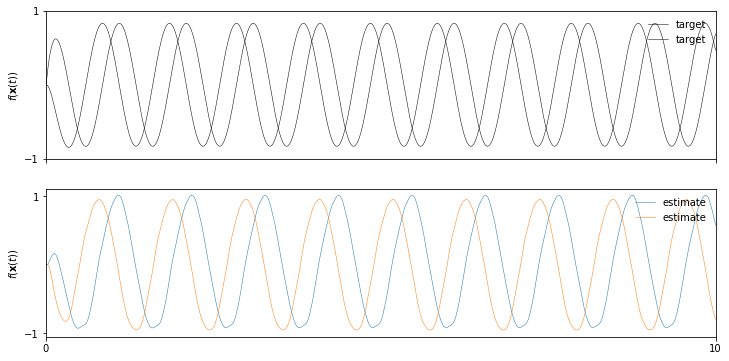

In [17]:
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((12, 6)), sharex=True)
ax.plot(times, tarX, label='target', color='k', linewidth=0.5)
ax2.plot(times, xhat, label='estimate', linewidth=0.5)
ax.set(xlim=((0, 10)), xticks=(()), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax2.set(xlim=((0, 10)), xticks=((0, 10)), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
plt.show()

### Moderate Firing Rates

In [10]:
times, tarX, xhat = run(
    neuron_type=LIF(),
    max_rates=Uniform(50, 100),
    nTrain=10,
    tTrain=10,
    tTest=10,
    eRate=3e-7,
    tTransTrain=0,
    nEns=100,
    dt=1e-3,
    tKick=0.1,
    fTarget=DoubleExp(1e-3, 1e-1),
    fSmooth=DoubleExp(1e-2, 1e-1),
    load=[])

Neuron type: LIF()
train d0, e0, w0 from pre to ens


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

train d1 and f1 for ens to compute the A matrix for the oscillator


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/trial, best loss: 0.009101757634908393]
train e1, w1 from ens to ens2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

estimating error


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

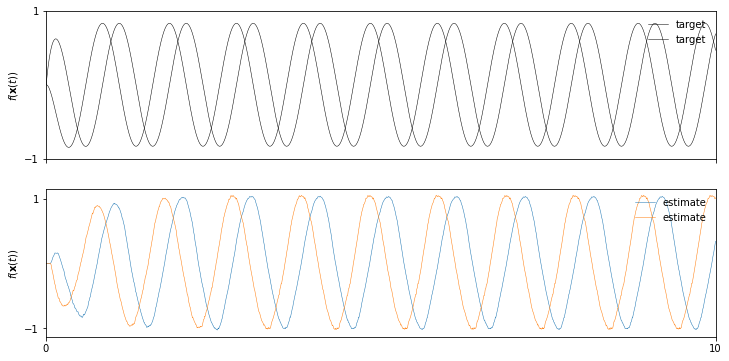

In [11]:
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((12, 6)), sharex=True)
ax.plot(times, tarX, label='target', color='k', linewidth=0.5)
ax2.plot(times, xhat, label='estimate', linewidth=0.5)
ax.set(xlim=((0, 10)), xticks=(()), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax2.set(xlim=((0, 10)), xticks=((0, 10)), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
plt.show()

### Low Firing Rates

In [12]:
times, tarX, xhat = run(
    neuron_type=LIF(),
    max_rates=Uniform(20, 40),
    nTrain=10,
    tTrain=10,
    tTest=10,
    eRate=3e-7,
    tTransTrain=0,
    nEns=100,
    dt=1e-3,
    tKick=0.1,
    fTarget=DoubleExp(1e-3, 1e-1),
    fSmooth=DoubleExp(1e-2, 1e-1),
    load=[])

Neuron type: LIF()
train d0, e0, w0 from pre to ens


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

train d1 and f1 for ens to compute the A matrix for the oscillator


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/trial, best loss: 0.030427832540556837]
train e1, w1 from ens to ens2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

estimating error


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

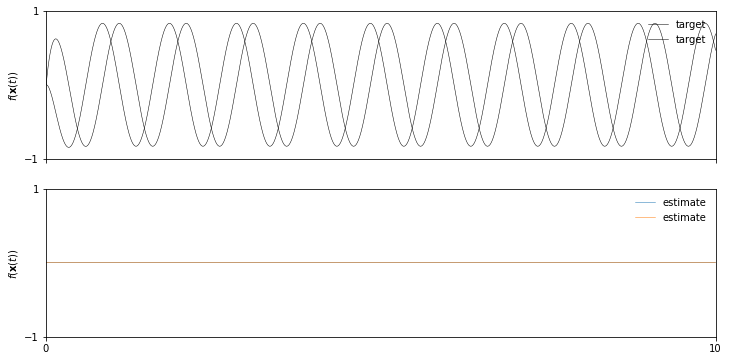

In [13]:
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((12, 6)), sharex=True)
ax.plot(times, tarX, label='target', color='k', linewidth=0.5)
ax2.plot(times, xhat, label='estimate', linewidth=0.5)
ax.set(xlim=((0, 10)), xticks=(()), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax2.set(xlim=((0, 10)), xticks=((0, 10)), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
plt.show()

Longer kick doesn't help

In [14]:
times, tarX, xhat = run(
    neuron_type=LIF(),
    max_rates=Uniform(20, 40),
    nTrain=10,
    tTrain=10,
    tTest=10,
    eRate=3e-7,
    tTransTrain=0,
    nEns=100,
    dt=1e-3,
    tKick=1,
    fTarget=DoubleExp(1e-3, 1e-1),
    fSmooth=DoubleExp(1e-2, 1e-1),
    load=[0,1,2])

Neuron type: LIF()
estimating error


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

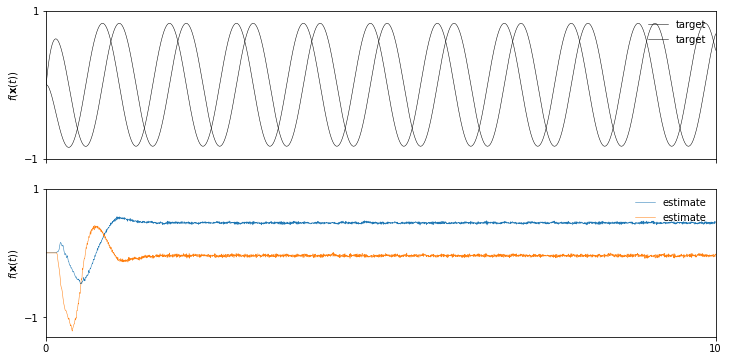

In [15]:
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((12, 6)), sharex=True)
ax.plot(times, tarX, label='target', color='k', linewidth=0.5)
ax2.plot(times, xhat, label='estimate', linewidth=0.5)
ax.set(xlim=((0, 10)), xticks=(()), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax2.set(xlim=((0, 10)), xticks=((0, 10)), yticks=((-1, 1)), ylabel=r"$f(\mathbf{x}(t))$")
ax.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
plt.show()